In [1]:
import ROOT
import numpy as np

Welcome to JupyROOT 6.24/06


In [2]:
oF = ROOT.TFile.Open("/cmpp/Lecture2_Fitting/workspaces/NumberCounting/ws_combined_NumberCounting_model.root")
oF.ls()


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

TFile**		/cmpp/Lecture2_Fitting/workspaces/NumberCounting/ws_combined_NumberCounting_model.root	
 TFile*		/cmpp/Lecture2_Fitting/workspaces/NumberCounting/ws_combined_NumberCounting_model.root	
  KEY: RooWorkspace	combined;1	combined
  KEY: TProcessID	ProcessID0;1	515c3ca0-98df-11ec-ae70-020011acbeef
  KEY: TDirectoryFile	SR_hists;1	SR_hists
  KEY: RooStats::HistFactory::Measurement	NumberCounting;1	NumberCounting


In [3]:
# Helper function to perform the fit
def minimize(fcn, save = False, retry_mode = 3):
  printLevel = ROOT.Math.MinimizerOptions.DefaultPrintLevel()
  msgLevel = ROOT.RooMsgService.instance().globalKillBelow()
  if printLevel < 0:
      ROOT.RooMsgService.instance().globalKillBelow(ROOT.RooFit.FATAL)
  
  strategy = ROOT.Math.MinimizerOptions.DefaultStrategy()
  save_def_strategy = strategy

  minimizer = ROOT.RooMinimizer(fcn)
  minimizer.optimizeConst(2)
  minimizer.setStrategy(strategy)
  minimizer.setPrintLevel(printLevel)
  minimizer.setMinimizerType(ROOT.Math.MinimizerOptions.DefaultMinimizerType())

  status = minimizer.minimize( ROOT.Math.MinimizerOptions.DefaultMinimizerType(), ROOT.Math.MinimizerOptions.DefaultMinimizerAlgo() )

  # Possibly re-trying if the fit didn't work
  if retry_mode == 0:
    if status != 0 and status != 1 and strategy < 2:
      strategy += 1
      logger.warning( f"Fit failed with status {status}. Retrying with strategy {strategy}" )
      minimizer.setStrategy(strategy)
      status = minimizer.minimize( ROOT.Math.MinimizerOptions.DefaultMinimizerType(), ROOT.Math.MinimizerOptions.DefaultMinimizerAlgo() )

    if status != 0 and status != 1 and strategy < 2:
      strategy += 1
      logger.warning( f"Fit failed with status {status}. Retrying with strategy {strategy}" )
      minimizer.setStrategy(strategy)
      status = minimizer.minimize( ROOT.Math.MinimizerOptions.DefaultMinimizerType(), ROOT.Math.MinimizerOptions.DefaultMinimizerAlgo() )

  else:
    for i in range(retry_mode):
      if status == 0 or status == 1: break
      logger.warning( f"Fit failed with status {status}. Retrying with strategy {strategy}." )
      minimizer.setStrategy(strategy)
      status = minimizer.minimize( ROOT.Math.MinimizerOptions.DefaultMinimizerType(), ROOT.Math.MinimizerOptions.DefaultMinimizerAlgo() )

  if printLevel < 0:
    ROOT.RooMsgService.insurance().setGlobalKillerBelow(msgLevel)
  ROOT.Math.MinimizerOptions.SetDefaultStrategy(save_def_strategy)

  if save:
    fitRes = minimizer.save( f"fitresult_{fcn.GetName()}", f"fitresult_{fcn.GetName()}" )
    return fitRes

In [4]:
def scanLikelihood(ws, parName="mu", scan_range=2, nPts=20, dataName = "obsData"):  
    # Reading in the elements needed for the fit
    mu = ws.var("mu")
    pdf = ws.pdf("simPdf")
    sbModel = ws.obj("ModelConfig")
    theData = ws.data(dataName)

    # Create a single set containing NP and POI to feed negative log-likelihood (NLL)
    params = ROOT.RooArgSet( sbModel.GetNuisanceParameters(), sbModel.GetParametersOfInterest() )
    par = ws.var(parName)
    if not par:
      print(f"ERROR: Parameter {parName} doesn't exist")
      return

    # Configuring Minuit
    ROOT.Math.MinimizerOptions.SetDefaultMinimizer("Minuit2")
    ROOT.Math.MinimizerOptions.SetDefaultStrategy(0)
    ROOT.Math.MinimizerOptions.SetDefaultPrintLevel(1)
    
    # Ensure all parameters are floating freely
    
    for v in params:
      print(v)
      v.setConstant(0)
    
    nll = pdf.createNLL( theData, ROOT.RooFit.Constrain(params), ROOT.RooFit.GlobalObservables(sbModel.GetGlobalObservables()), ROOT.RooFit.Offset(1) )
    
    # Performing unconditional fit (all parameters floating)
    minimize(nll)
    
    # Saving the value of the NLL at the best fit value
    nll_best = nll.getVal()
    mu_hat = par.getVal()
    
    print(f"nll_best = {nll_best} ; mu_hat = {mu_hat}")
  
    # Storing values for plotting
    x_array, y_array = np.zeros(nPts+1), np.zeros(nPts+1)
    print(x_array)
    cnt = 0
    passedMin = False # Variable to check whether minimum was passed
    for i in range(0,nPts):
        val = mu_hat - scan_range + 2 * scan_range * i / (nPts - 1)
        print(i, val)
    
        if val > mu_hat and not passedMin:
            passedMin = True
            x_array[cnt] = mu_hat
            y_array[cnt] = 0
            cnt += 1

        # Fix the parameter to its point in the scan and fit
        par.setVal(val)
        print(par)
        par.setConstant(1)
        minimize(nll)

        # Saving -2log(L(par/L(par_hat))
        dnllx2 = 2*(nll.getVal()-nll_best)
        x_array[cnt] = val
        y_array[cnt] = dnllx2
        cnt += 1
        print(f"[{i+1} of {nPts}] {parName} = {val}, -2lnLambda = {dnllx2} (best fit = {mu_hat})")
    
    return x_array, y_array, parName, scan_range, mu_hat


In [12]:
# Helper for drawing
def drawLikelihoodScan(x_array, y_array, parName, scan_range, mu_hat):
    c = ROOT.TCanvas(f"Likelihood Scan {parName} (scan_range = {scan_range})")
    # Plotting the result
    g = ROOT.TGraph(len(x_array), x_array, y_array)
    g.SetTitle("Likelihood Scan")
    g.Draw("ALP*")
    g.GetXaxis().SetTitle(parName)
    g.GetYaxis().SetTitle("-2 ln #Lambda")
    g.Draw("LP*")

    l = ROOT.TLine()
    l.SetLineStyle(2)
    l.SetLineWidth(2)
    l.SetLineColor(ROOT.kRed)
    l.DrawLine(mu_hat-scan_range, 1 ,mu_hat+scan_range, 1)
    l.SetLineColor(ROOT.kBlue)
    l.DrawLine(mu_hat-scan_range, 4 ,mu_hat+scan_range, 4)
    
    c.Draw()
    c.Print(".png")
    return c.Clone()

In [10]:
# Reading in the workspace
ws = oF.Get("combined")

x_array, y_array, parName, scan_range, mu_hat = scanLikelihood(ws)


RooRealVar::Lumi = 1  L(0 - 10) 

RooRealVar::mu = 1  L(0 - 100) 

nll_best = -37.07106355172965 ; mu_hat = 1.5939869289060105
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 -0.40601307109398954
RooRealVar::mu = 0 +/- 0.776528  L(0 - 100) 

[1 of 20] mu = -0.40601307109398954, -2lnLambda = 7.125823916587976 (best fit = 1.5939869289060105)
1 -0.19548675530451587
RooRealVar::mu = 0 +/- 0.776528 C  L(0 - 100) 

[2 of 20] mu = -0.19548675530451587, -2lnLambda = 7.125823781192963 (best fit = 1.5939869289060105)
2 0.015039560484957804
RooRealVar::mu = 0.0150396 +/- 0.776528 C  L(0 - 100) 

[3 of 20] mu = 0.015039560484957804, -2lnLambda = 6.952736271614782 (best fit = 1.5939869289060105)
3 0.22556587627443148
RooRealVar::mu = 0.225566 +/- 0.776528 C  L(0 - 100) 

[4 of 20] mu = 0.22556587627443148, -2lnLambda = 4.847378871550077 (best fit = 1.5939869289060105)
4 0.43609219206390515
RooRealVar::mu = 0.436092 +/- 0.776528 C  L(0 - 100) 

[5 of 20] mu = 0.43609219206390515, 

Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -3.044377767 Edm =       0.424292289 NCalls =      9
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -3.044377767 Edm =       0.424292289 NCalls =      9
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      -3.410907908 Edm =    0.001983649396 NCalls =     17
Info in <Minuit2>: VariableMetricBuilder    2 - FCN =      -3.412676035 Edm =   6.576327054e-06 NCalls =     22
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      0.1649236102 Edm =     0.01470876774 NCalls =      5
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 500
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      0.1649236102 Edm =     0.01470876774 NCalls =      5
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      0.1502359234 Edm =   6.798890394e-08 NCalls =      8
Info in <Mi

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Likelihood Scan mu (scan_range = 2)
Info in <TCanvas::Print>: png file ./Likelihood Scan mu (scan_range = 2).png has been created


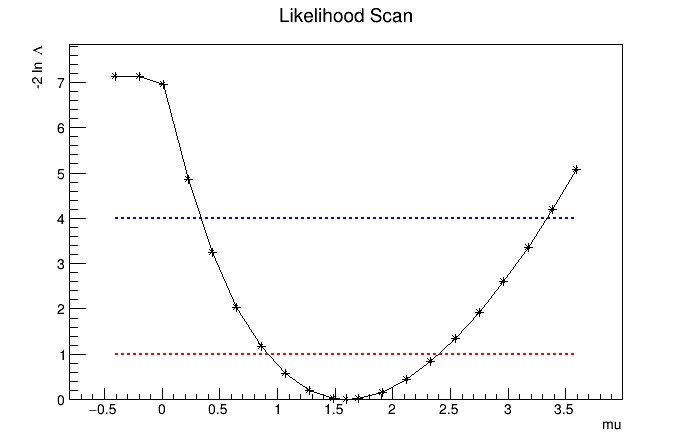

In [13]:
c = drawLikelihoodScan(x_array, y_array, parName, scan_range, mu_hat)
c.Draw()

RooRealVar::Lumi = 0.995917 +/- 0.0189352  L(0 - 10) 

RooRealVar::mu = 3.59399 +/- 0.776528 C  L(0 - 100) 

nll_best = -37.071026014117294 ; mu_hat = 0.9999931469383339
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 0.9599931469383338
RooRealVar::Lumi = 0.959993 +/- 0.0188785  L(0 - 10) 

[1 of 20] Lumi = 0.9599931469383338, -2lnLambda = 4.433573273727703 (best fit = 0.9999931469383339)
1 0.9642036732541233
RooRealVar::Lumi = 0.964204 +/- 0.0188785 C  L(0 - 10) 

[2 of 20] Lumi = 0.9642036732541233, -2lnLambda = 3.549434011806241 (best fit = 0.9999931469383339)
2 0.9684141995699128
RooRealVar::Lumi = 0.968414 +/- 0.0188785 C  L(0 - 10) 

[3 of 20] Lumi = 0.9684141995699128, -2lnLambda = 2.7635220451062423 (best fit = 0.9999931469383339)
3 0.9726247258857023
RooRealVar::Lumi = 0.972625 +/- 0.0188785 C  L(0 - 10) 

[4 of 20] Lumi = 0.9726247258857023, -2lnLambda = 2.0758290922722438 (best fit = 0.9999931469383339)
4 0.9768352522014917
RooRealVar::Lumi = 0.976835 +/- 

Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -3.021282462 Edm =       2.461644704 NCalls =      9
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -3.021282462 Edm =       2.461644704 NCalls =      9
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      -5.533027618 Edm =     0.02562818252 NCalls =     14
Info in <Minuit2>: VariableMetricBuilder    2 - FCN =      -5.561246086 Edm =   3.832712248e-05 NCalls =     19
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -3.331205126 Edm =     0.01341596749 NCalls =      5
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 500
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =      -3.331205126 Edm =     0.01341596749 NCalls =      5
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =      -3.344459449 Edm =   4.286653537e-06 NCalls =      8
Info in <Mi

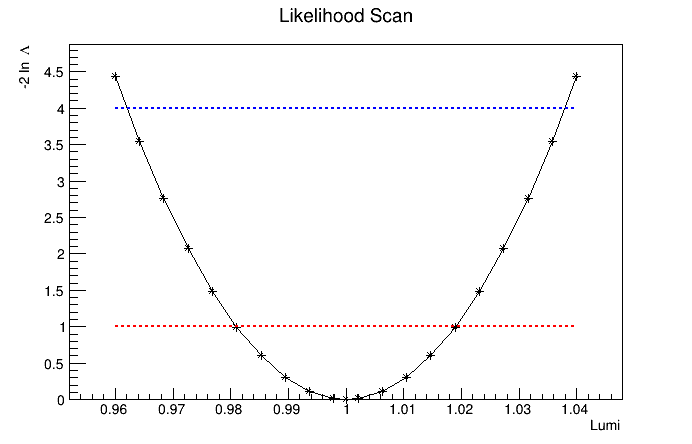

In [14]:
x_array, y_array, parName, scan_range, mu_hat = scanLikelihood(ws, "Lumi", 0.04, 20)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Likelihood Scan Lumi (scan_range = 0.04)
Info in <TCanvas::Print>: png file ./Likelihood Scan Lumi (scan_range = 0.04).png has been created


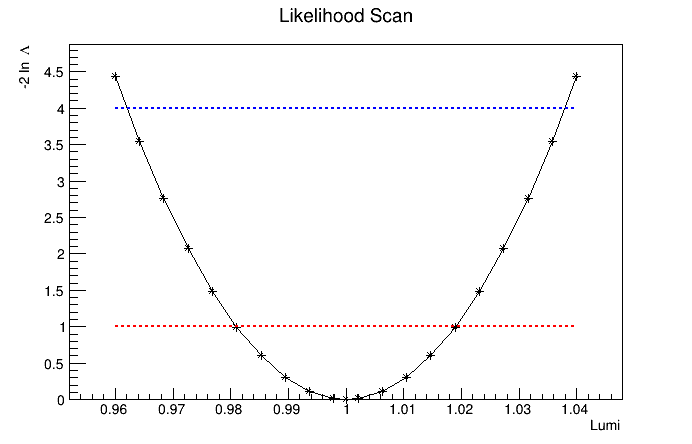

In [15]:
c = drawLikelihoodScan(x_array, y_array, parName, scan_range, mu_hat)
c.Draw()